In [1]:
# -*- coding: utf-8 -*-
import os
import makeDataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import cv2
from IPython import display
import random


#from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline


emptyMnist = makeDataset.dataSet([])

with open("./testImage.data" , 'rb') as f:
    testImage = pickle.load(f)
with open("./testLabel.data" , 'rb') as f:
    testLabel = pickle.load(f)
with open("./trainImage.data" , 'rb') as f:
    trainImage = pickle.load(f)
with open("./trainLabel.data" , 'rb') as f:
    trainLabel = pickle.load(f)    

with open("./testAnswer.data" , 'rb') as f:
    testAnswer = pickle.load(f)
    
with open("./trainAnswer.data" , 'rb') as f:
    trainAnswer = pickle.load(f)
    
    
emptyMnist.train.images = trainImage
emptyMnist.train.labels = trainLabel
emptyMnist.test.images = testImage
emptyMnist.test.labels = testLabel
mnist = emptyMnist
mnist.train.num_examples = len(mnist.train.labels)
mnist.test.num_examples = len(mnist.test.labels)
numOfTests = len(mnist.test.labels)

print("원본 이미지 사이즈는 682 X 700 입니다.")
print("64 X 64 로 리사이즈 되었습니다.")
print("각각의 좌표는 0.00 ~ 1.0 로 스케일 하였습니다.")
print("실제 좌표와 추정 좌표가 잘 맞는지 확인 하기 위해서 testAnswer를 사용 합니다")
print("다시 좌표를 복원 할때는 175X170 사이즈를 고려 하여 스케일 해 주어야 합니다")

"""
for i in range(len(emptyMnist.train.images)):
    img = emptyMnist.train.images[i].reshape((64,64))
    sobel = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=1)
    emptyMnist.train.images[i] = sobel.reshape((4096))

for i in range(len(emptyMnist.test.images)):
    img = emptyMnist.test.images[i].reshape((64,64))
    sobel = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=1)
    emptyMnist.test.images[i] = sobel.reshape((4096))"""

원본 이미지 사이즈는 682 X 700 입니다.
64 X 64 로 리사이즈 되었습니다.
각각의 좌표는 0.00 ~ 1.0 로 스케일 하였습니다.
실제 좌표와 추정 좌표가 잘 맞는지 확인 하기 위해서 testAnswer를 사용 합니다
다시 좌표를 복원 할때는 175X170 사이즈를 고려 하여 스케일 해 주어야 합니다


'\nfor i in range(len(emptyMnist.train.images)):\n    img = emptyMnist.train.images[i].reshape((64,64))\n    sobel = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=1)\n    emptyMnist.train.images[i] = sobel.reshape((4096))\n\nfor i in range(len(emptyMnist.test.images)):\n    img = emptyMnist.test.images[i].reshape((64,64))\n    sobel = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=1)\n    emptyMnist.test.images[i] = sobel.reshape((4096))'

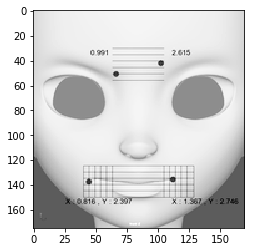

In [3]:
plt.imshow(trainAnswer[3].reshape((175,170))*-1, cmap='Greys')

In [4]:
# 변수들을 설정한다.
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, [None, 4096])
x = tf.nn.dropout(x, keep_prob)
W1 = tf.Variable(tf.random_normal([4096, 1000] , stddev=0.001))
b1 = tf.Variable(tf.zeros([1000]))
y1 = tf.matmul(x, W1) + b1
y1 = tf.nn.relu(y1+0.000001)

W2 = tf.Variable(tf.random_normal([1000, 8] , stddev=0.001))
b2 = tf.Variable(tf.zeros([8])) 
y2 = tf.matmul(y1, W2) + b2 
#y2 = tf.nn.sigmoid(y2+0.000001)

#W3 = tf.Variable(tf.random_normal([50, 8] , stddev=0.001))
#b3 = tf.Variable(tf.zeros([8])) 
#y3 = tf.matmul(y2, W3) + b3
#y3 = tf.nn.relu(y3+0.000001)


#W4 = tf.Variable(tf.random_normal([100, 8] , stddev=0.001))
#b4 = tf.Variable(tf.zeros([8])) 
#y4 = tf.matmul(y3, W4) + b4
y5 = y2
"모델 설정 완료"
print(b1)

<tf.Variable 'Variable_1:0' shape=(1000,) dtype=float32_ref>


In [5]:
# cross-entropy 모델을 설정한다.
y_ = tf.placeholder(tf.float32, [None, 8])
#cost = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y5), reduction_indices=[1])) # crossEntropy
cost = tf.reduce_mean(tf.square( y_ - y5))
learning_rate = tf.placeholder(tf.float32, shape=[])
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)#
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)
"최적화 프로그램"

'최적화 프로그램'

In [6]:
# 경사하강법으로 모델을 학습한다.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
"변수 초기화"

'변수 초기화'

In [7]:
def testMnist(cost , y , images ,labels ,indexes , NumOfShow ):
    global mnist
    print("Test Start" , len(mnist.train.images))
    # 학습된 모델이 얼마나 정확한지를 출력한다.
    if len(images) == 0:
        return None
    else:
        costs = []
        result = sess.run([cost , y] , feed_dict={x: images, y_: labels})
        for lb_index in range(len(labels)):
            cost_ = 0
            for xy_index in range(8):
                cost_ += abs(labels[lb_index][xy_index] - result[1][lb_index][xy_index])
            costs.append(cost_)
        cost2 = sorted(costs)
        #print("cost2_2" , cost2[45:])
        if len(cost2[len(labels) - NumOfShow :len(labels)]) > 0:
            print("forward" , cost2[:5])
            print("backword" , cost2[len(labels) - 5 :len(labels)])
        c_index = []
        cost2Add = []
        for i in range(len(labels)):# - NumOfShow , len(labels)):
            c_index.append(costs.index(cost2[i]))
        for i in range(len(labels)-3 , len(labels)):# - NumOfShow , len(labels)):
            #if cost2[i] > 0.900:##############!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#############
            pass#cost2Add.append(indexes[costs.index(cost2[i])])
                
        newAry = list(mnist.train.images)
        newLabel = list(mnist.train.labels)
        for aindex in cost2Add:
            newAry.append(list(mnist.train.images[aindex]))
            newLabel.append(list(mnist.train.labels[aindex]))
        mnist.train.images = np.array(newAry)
        mnist.train.labels = np.array(newLabel)
        
        
        for i in range(NumOfShow):
            lb = result[1][costs.index(cost2[i])]
            image = (testAnswer[indexes[costs.index(cost2[i])]].reshape((175,170))) + 0.7
            for ii , l in enumerate(lb):
                if ii%2 == 0:
                    yy = int(l*175.0) # Y 리스케일링
                else:
                    xx = int(l*170.0) # X 리스케일링
                    cv2.circle(image,(yy , xx), 2, (0,255,0), -1)#테스트 이미지에 좌표를 그려준다
            plt.imshow(image)#테스트 이미지 출력
            display.display(plt.gcf())#이미지를 실시간으로 표현한다

        """for i in range(len(costs)-1 , len(costs)- NumOfShow -1 , -1):
            lb = result[1][costs.index(cost2[i])]
            image = (trainAnswer[indexes[costs.index(cost2[i])]].reshape((175,170))) + 0.7
            for ii , l in enumerate(lb):
                if ii%2 == 0:
                    yy = int(l*175.0) # Y 리스케일링
                else:
                    xx = int(l*170.0) # X 리스케일링
                    cv2.circle(image,(yy , xx), 2, (0,255,0), -1)#테스트 이미지에 좌표를 그려준다
            plt.imshow(image)#테스트 이미지 출력
            display.display(plt.gcf())#이미지를 실시간으로 표현한다"""
        return result[0]


In [9]:
def run(epoch = 500 ,checkpoint = [50,10] ,numOfTest = 50 , showCnt = 1 ,lr = 0.001):
    global cost,mnist
    costs = []
    test_images = []
    test_labels = []
    indexes = []
    train_Images = []
    train_Labels = []
    for i in range(epoch):
        if i%checkpoint[1] == 0:
            try:
                costs.append(testMnist(cost , y5 , test_images[0]-test_images , test_labels  , indexes , 0 ))
            except:
                pass


        if i%checkpoint[0] == 0 :
            print("train epoch is " , i)
            print("cost : " , costs)
            costs=[]
            test_images = []
            test_labels = []
            indexes = []
            for _ in range(numOfTest):
                index = random.randrange(0,numOfTests)
                indexes.append(index)
                test_images.append(mnist.test.images[index])
                test_labels.append(mnist.test.labels[index])

            testMnist(cost , y5 ,mnist.train.images[0] - test_images , test_labels  , indexes , showCnt )
        #batch_xs, batch_ys = mnist.next_batch(100)
        train_Images = []
        train_Labels = []
        indexes = []
        for _ in range(1000):
            index = random.randrange(0,len(mnist.train.images))
            train_Images.extend([mnist.train.images[index]]*5)
            train_Labels.extend([mnist.train.labels[index]]*5)
        #train_Images = train_Images*5
        #train_Labels = train_Labels*5
        train_Images = np.array(train_Images)
        train_Labels = np.array(train_Labels)
        sess.run(train_step, feed_dict={x:  mnist.train.images[0] - train_Images, y_: train_Labels , learning_rate: lr ,keep_prob: 0.5})
        
"실행 함수"

'실행 함수'

lr is   0.01
train epoch is  0
cost :  []
Test Start 2667
forward [3.6266505786552088, 3.6266505786552088, 3.644668308132665, 3.644668308132665, 3.6467430246678898]
backword [4.16913544002003, 4.1804645833188037, 4.1984004277798519, 4.2546564850987965, 4.2546564850987965]


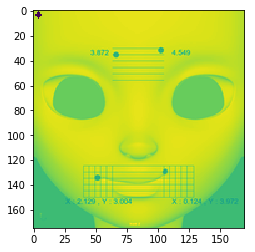

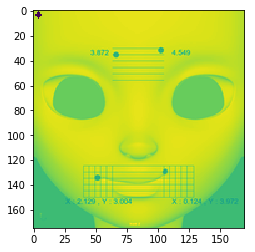

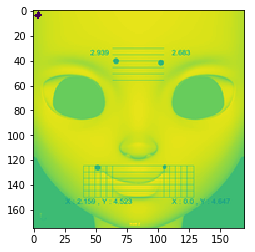

Test Start 2667
Test Start 2667
Test Start 2667
train epoch is  10
cost :  [0.21815589, 0.22705542, 0.28665096]
Test Start 2667
forward [0.62434097044101466, 0.62434097044101466, 0.68994949304476849, 0.73668024200724957, 0.73668024200724957]
backword [2.8288027543118579, 2.9818715767322317, 3.0395914382899734, 3.2435051424918813, 3.3439827737629839]


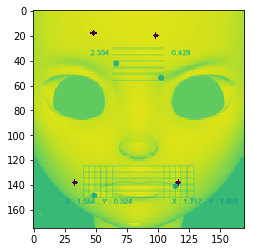

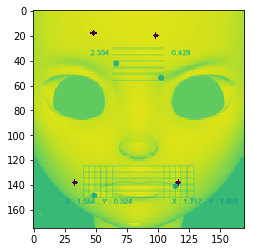

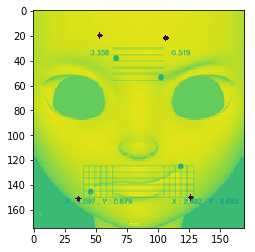

Test Start 2667
Test Start 2667
Test Start 2667
train epoch is  20
cost :  [0.27733335, 0.39965811, 0.55320966]
Test Start 2667
forward [0.30793823220982408, 0.30793823220982408, 0.32356442087587589, 0.32356442087587589, 0.35741953440704216]
backword [1.4744378447123485, 1.5055530520975182, 1.5055530520975182, 2.1060667396072619, 2.1060667396072619]


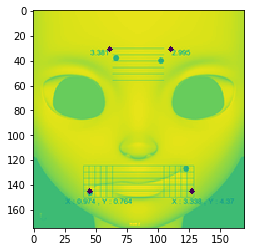

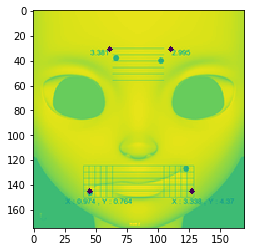

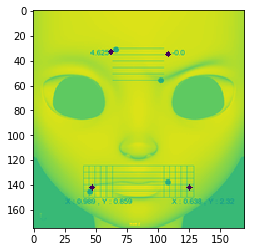

Test Start 2667
Test Start 2667
Test Start 2667
Test Start 2667
train epoch is  30
cost :  [2.1150591, 2.5637712, 2.9557421, 3.2792728]
Test Start 2667
forward [0.10937174780687631, 0.11868636732286772, 0.11868636732286772, 0.13452231187401656, 0.13860904636429583]
backword [1.1695133307609213, 1.1944230203922626, 1.1944230203922626, 1.2361336159068277, 1.2361336159068277]


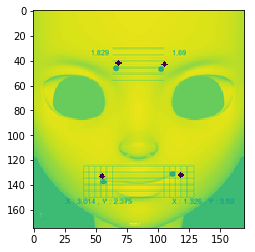

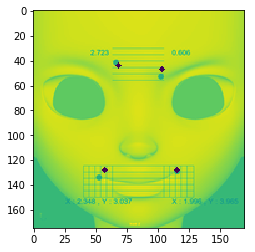

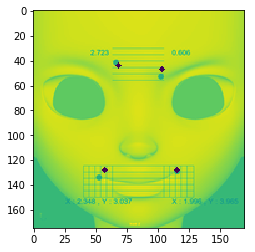

Test Start 2667
Test Start 2667
Test Start 2667
train epoch is  40
cost :  [0.28277847, 0.29225719, 0.30646417]
Test Start 2667
forward [0.082009449896619957, 0.084214281289848841, 0.12814498187355078, 0.12814498187355078, 0.13780648957956582]
backword [0.96031102114497924, 0.96031102114497924, 1.041637087057727, 1.041637087057727, 1.0629588225516928]


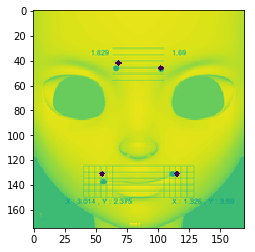

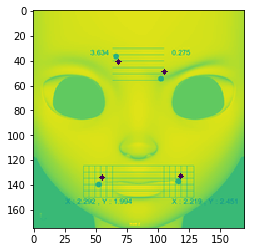

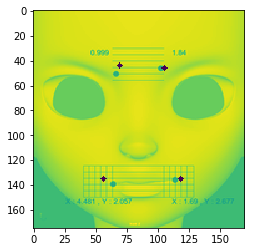

Test Start 2667
Test Start 2667
Test Start 2667
train epoch is  50
cost :  [0.34742051, 0.35238817, 0.35642663]
Test Start 2667
forward [0.10085764378366166, 0.10085764378366166, 0.10319705998601672, 0.10319705998601672, 0.10357890529773242]
backword [0.66210127746178782, 0.66210127746178782, 0.66210127746178782, 0.7730601089554956, 1.1810308307890169]


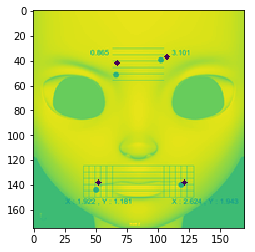

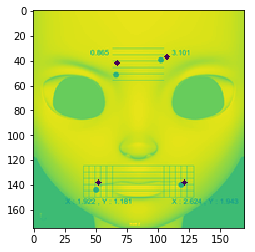

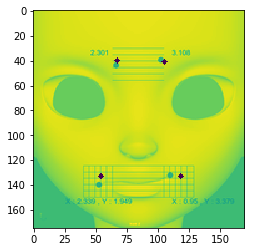

Test Start 2667


KeyboardInterrupt: 

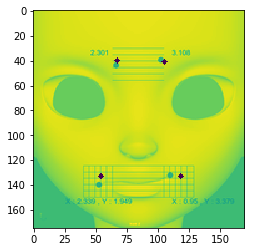

In [13]:


for ___ in range(1000):
    #lr_ = 0.0001
    #print("lr is  " , lr_)
    #run(epoch=100,checkpoint = [10,3] , showCnt = 5 , lr =lr_)
    lr_ = 0.01
    print("lr is  " , lr_)
    run(epoch=10000,checkpoint = [10,3] , showCnt = 3 , lr =lr_ , numOfTest=len(mnist.test.images))
#0.240
